# Business understanding

Generator planet 
- format wejściowy plików:  1920px/1080px
- format wyjściowy plików:  128px/128px

In [1]:
# import niezbednych bibliotek
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

In [2]:
# wersja tensorflow
print('tensorflow ver: ', tf.__version__)
print('keras ver     : ', tf.keras.__version__)

tensorflow ver:  2.10.1
keras ver     :  2.10.0


# Data understanding and data preparation

Dataset zrobiony z modeli udostępnionych przez NASA na stronie: nasa.gov
- 12 planet/gwiazd
- 100 zdjęć na planetę/gwiazde

wybór - 4 planet/gwiazd

In [3]:
dir_directory_path = './DATA/v1'

images_data = []
images_labels = []
    
subfolders = [ f.path for f in os.scandir(dir_directory_path) if f.is_dir() ]

for dir_path in subfolders:
    print('Loading data from folder', dir_path.replace("\\", "/"))

    if dir_path.find('earth') == -1 and dir_path.find('sun') == -1 and dir_path.find('mars') == -1: 
        continue
    
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                dir_path, 
                label_mode=None, 
                image_size=(128, 230), 
                batch_size=32,
                #color_mode='grayscale'
            )
    
    for i in dataset:
        for ii in i:            
            new_img = ii[0:128, 50: 178]
            images_data.append(new_img)
            images_labels.append(dir_path.replace(dir_directory_path, '').replace('\\',''))
                        
images_data = np.asarray(images_data)
images_labels = np.asarray(images_labels)

new_images_data = []
new_images_labels = []

for idx in range(0, images_data.shape[0]):
    img = Image.fromarray(np.uint8(images_data[idx]))
    class_name = images_labels[idx]
    
    new_images_data.append(np.asarray(img))
    new_images_labels.append(class_name)
    
    for i in range(180,360,180):
        rotated_img = img.rotate(i)
        new_images_data.append(np.asarray(rotated_img))
        new_images_labels.append(class_name)
                        
images_data = np.asarray(new_images_data)
images_labels = np.asarray(new_images_labels)        

label_encoder = LabelEncoder()
images_labels_num = label_encoder.fit_transform(images_labels)

print()
print('Shapes:')
print('images_labels      :', images_labels.shape)
print('-----------------------------')
print('images_data        :', images_data.shape)
print('images_labels_num  :', images_labels_num.shape)

Loading data from folder ./DATA/v1/ceres
Loading data from folder ./DATA/v1/earth
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/earth_moon
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/eris
Loading data from folder ./DATA/v1/hamuea
Loading data from folder ./DATA/v1/jupiter
Loading data from folder ./DATA/v1/makemake
Loading data from folder ./DATA/v1/mars
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/mercury
Loading data from folder ./DATA/v1/pluto
Loading data from folder ./DATA/v1/sun
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/venus

Shapes:
images_labels      : (800,)
-----------------------------
images_data        : (800, 128, 128, 3)
images_labels_num  : (800,)


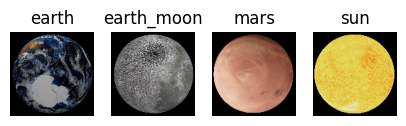

In [4]:
np.random.seed(100)

idx = 0
fig = plt.figure(figsize=(5, 5))
for i in np.unique(images_labels_num):    
    idx += 1
    class_position = np.where(images_labels_num  == i)[0]
    class_position = np.random.choice(class_position)
    plt.subplot(4, 4, idx)
    plt.imshow(images_data[class_position] / 255.)
    plt.title(images_labels[class_position])    
    plt.axis('off')
plt.show()
plt.close(fig)

In [5]:
train_images = images_data
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
train_images.shape

(800, 128, 128, 3)

# Modeling

In [7]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1  

In [8]:
def build_generator(image_size):
    
    size = int(image_size / 4)
    
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(size * size * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((size, size, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())    
    model.add(layers.LeakyReLU())

    # last layer 
    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
        
    return model     


# build the generator model
generator = build_generator(128) 
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 262144)            26476544  
                                                                 
 batch_normalization (BatchN  (None, 262144)           1048576   
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 262144)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      51

c:\APLIKACJE\PyDataScience\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [9]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(128, (5, 5), padding="same", strides=(2, 2), input_shape=input_shape))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # flatten and apply dropout
    model.add(layers.Flatten())
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model


# build the discriminator model
discriminator = build_discriminator(128, 128, 3) 
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       9728      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        204864    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 flatten (Flatten)           (None, 65536)           

In [10]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}     

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(5, 5))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('./results_128_v2/epoch_{:03d}.jpg'.format(epoch + 1)) 
        if epoch == 0 or epoch % 10 == 0:
            plt.show()
        plt.close(fig)
                
        for i in range(self.num_img):
            fig = plt.figure(figsize=(1.6, 1.6))
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
            plt.savefig('./results_128_v2/images/S{:03d}_E{:03d}_IMG{:03d}.jpg'.format(SESJA, epoch + 1, i + 1)) 
            plt.close(fig)
        if epoch == 0 or epoch % 5 == 0:
            self.model.generator.save('./results_128_v2/generator_128_S{:03d}_E{:03d}_.h5'.format(SESJA, epoch + 1))

    def on_train_end(self, logs=None):
        self.model.generator.save('./results_128_v2/generator_128_S{:03d}_v2.h5'.format(SESJA))

In [12]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

D_LR = 0.001 # UPDATED: discriminator learning rate
G_LR = 0.003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Evaluation

Epoch 1/50
25/25 [==============================] - ETA: 0s - d_loss: 0.5444 - g_loss: 1.1696

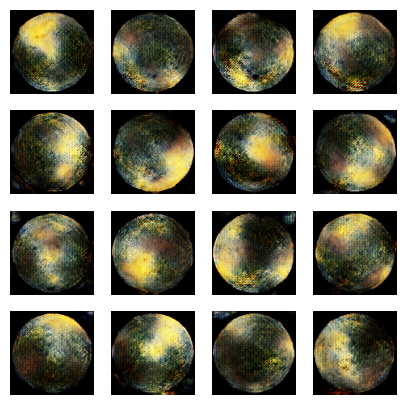

25/25 [==============================] - 159s 6s/step - d_loss: 0.5444 - g_loss: 1.1696
Epoch 2/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.4689 - g_loss: 1.1916
Epoch 3/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.4152 - g_loss: 1.1000
Epoch 4/50
25/25 [==============================] - 157s 6s/step - d_loss: 0.4322 - g_loss: 1.3582
Epoch 5/50
25/25 [==============================] - 157s 6s/step - d_loss: 0.4313 - g_loss: 0.9078
Epoch 6/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.4510 - g_loss: 1.3687
Epoch 7/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.7796 - g_loss: 1.4787
Epoch 8/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.5840 - g_loss: 1.4563
Epoch 9/50
25/25 [==============================] - 157s 6s/step - d_loss: 0.4813 - g_loss: 1.2070
Epoch 10/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.4409 - g_loss: 1.2462
Epoch 11/50
25/25 [=

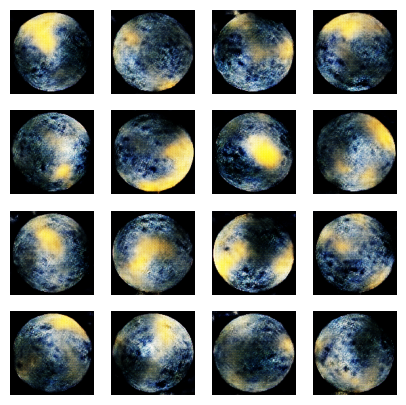

25/25 [==============================] - 159s 6s/step - d_loss: 0.5946 - g_loss: 1.6849
Epoch 12/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.6752 - g_loss: 1.7331
Epoch 13/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.3897 - g_loss: 1.1354
Epoch 14/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.3972 - g_loss: 0.9750
Epoch 15/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.5659 - g_loss: 1.7546
Epoch 16/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.6634 - g_loss: 1.9036
Epoch 17/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.3544 - g_loss: 0.9587
Epoch 18/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.5819 - g_loss: 2.1495
Epoch 19/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.4328 - g_loss: 1.4700
Epoch 20/50
25/25 [==============================] - 158s 6s/step - d_loss: 0.4766 - g_loss: 1.3329
Epoch 21/50


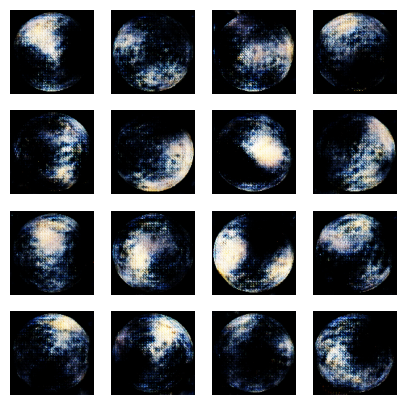

25/25 [==============================] - 158s 6s/step - d_loss: 0.4864 - g_loss: 1.8869
Epoch 22/50
25/25 [==============================] - 158s 6s/step - d_loss: -0.1309 - g_loss: 0.5960
Epoch 23/50
25/25 [==============================] - 158s 6s/step - d_loss: -1.4505 - g_loss: 1.4217e-17
Epoch 24/50
25/25 [==============================] - 158s 6s/step - d_loss: 106.9539 - g_loss: 316.5616
Epoch 25/50
25/25 [==============================] - 158s 6s/step - d_loss: 20.1218 - g_loss: 310.8360
Epoch 26/50
25/25 [==============================] - 158s 6s/step - d_loss: -8.5626 - g_loss: 4.7590
Epoch 27/50
25/25 [==============================] - 158s 6s/step - d_loss: 6.7485 - g_loss: 168.0621
Epoch 28/50
25/25 [==============================] - 158s 6s/step - d_loss: -8.2932 - g_loss: 3.8446
Epoch 29/50
25/25 [==============================] - 158s 6s/step - d_loss: -3.0688 - g_loss: 34.0977
Epoch 30/50
25/25 [==============================] - 159s 6s/step - d_loss: 23.4236 - g_loss:

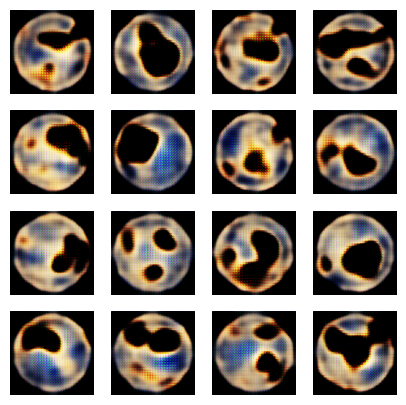

25/25 [==============================] - 158s 6s/step - d_loss: 3.2249 - g_loss: 43.5958
Epoch 32/50
25/25 [==============================] - 157s 6s/step - d_loss: 0.0109 - g_loss: 3.1956
Epoch 33/50
25/25 [==============================] - 157s 6s/step - d_loss: 2.2261 - g_loss: 8.1139
Epoch 34/50
25/25 [==============================] - 158s 6s/step - d_loss: 1.8611 - g_loss: 21.4671
Epoch 35/50
25/25 [==============================] - 157s 6s/step - d_loss: 0.2754 - g_loss: 4.7983
Epoch 36/50
25/25 [==============================] - 157s 6s/step - d_loss: -1.0183 - g_loss: 0.4213
Epoch 37/50
25/25 [==============================] - 157s 6s/step - d_loss: -2.2570 - g_loss: 0.0269
Epoch 38/50
25/25 [==============================] - 156s 6s/step - d_loss: -2.7977 - g_loss: 1.3736
Epoch 39/50
25/25 [==============================] - 156s 6s/step - d_loss: -0.6664 - g_loss: 13.3267
Epoch 40/50
25/25 [==============================] - 157s 6s/step - d_loss: 4.1364 - g_loss: 38.8981
Epoc

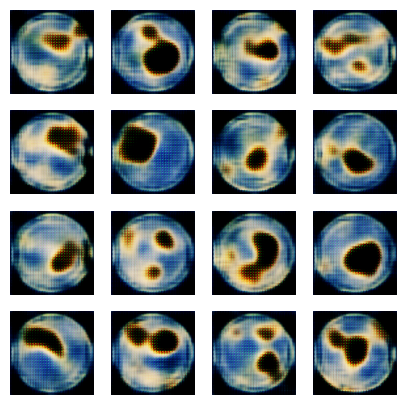

25/25 [==============================] - 157s 6s/step - d_loss: 0.8726 - g_loss: 108.0442
Epoch 42/50
25/25 [==============================] - 157s 6s/step - d_loss: 3.5477 - g_loss: 37.5975
Epoch 43/50
25/25 [==============================] - 159s 6s/step - d_loss: -0.9001 - g_loss: 14.8697
Epoch 44/50
25/25 [==============================] - 158s 6s/step - d_loss: -1.7165 - g_loss: 17.7702
Epoch 45/50
25/25 [==============================] - 158s 6s/step - d_loss: 4.6426 - g_loss: 34.0328
Epoch 46/50
25/25 [==============================] - 160s 6s/step - d_loss: -4.3863 - g_loss: 0.7571
Epoch 47/50
25/25 [==============================] - 158s 6s/step - d_loss: -1.1608 - g_loss: 30.3660
Epoch 48/50
25/25 [==============================] - 158s 6s/step - d_loss: -1.9762 - g_loss: 12.4696
Epoch 49/50
25/25 [==============================] - 158s 6s/step - d_loss: -4.7005 - g_loss: 39.8706
Epoch 50/50
25/25 [==============================] - 157s 6s/step - d_loss: 16.5308 - g_loss: 102

In [17]:
# number of epochs
NUM_EPOCHS = 50 
SESJA = 4

dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

# Deployment

Tworzenie gifa z wyników generowania planet w każdej epoce

In [ ]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "./results_128_v2/*.jpg"
fp_out = "./results_128_v2/epochs128.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1, loop=0)